/etc/anaconda3/envs/util_tool/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/etc/anaconda3/envs/util_tool/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


均值哈希算法相似度aHash： 0
差值哈希算法相似度dHash： 0
感知哈希算法相似度pHash： 0
三直方图算法相似度： 1.0
单通道的直方图 1.0
num sum: 0.0
1.00 1.00 1.00 1.00 1.00 


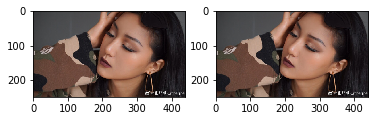

In [45]:
import cv2
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt


def aHash(img):
    # 均值哈希算法
    # 缩放为8*8
    img = cv2.resize(img, (8, 8))
    # 转换为灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # s为像素和初值为0，hash_str为hash值初值为''
    s = 0
    hash_str = ''
    # 遍历累加求像素和
    for i in range(8):
        for j in range(8):
            s = s + gray[i, j]
    # 求平均灰度
    avg = s / 64
    # 灰度大于平均值为1相反为0生成图片的hash值
    for i in range(8):
        for j in range(8):
            if gray[i, j] > avg:
                hash_str = hash_str + '1'
            else:
                hash_str = hash_str + '0'
    return hash_str


def dHash(img):
    # 差值哈希算法
    # 缩放8*8
    img = cv2.resize(img, (9, 8))
    # 转换灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hash_str = ''
    # 每行前一个像素大于后一个像素为1，相反为0，生成哈希
    for i in range(8):
        for j in range(8):
            if gray[i, j] > gray[i, j + 1]:
                hash_str = hash_str + '1'
            else:
                hash_str = hash_str + '0'
    return hash_str


def pHash(img):
    # 感知哈希算法
    # 缩放32*32
    img = cv2.resize(img, (32, 32))  # , interpolation=cv2.INTER_CUBIC

    # 转换为灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 将灰度图转为浮点型，再进行dct变换
    dct = cv2.dct(np.float32(gray))
    # opencv实现的掩码操作
    dct_roi = dct[0:8, 0:8]

    hash = []
    avreage = np.mean(dct_roi)
    for i in range(dct_roi.shape[0]):
        for j in range(dct_roi.shape[1]):
            if dct_roi[i, j] > avreage:
                hash.append(1)
            else:
                hash.append(0)
    return hash


def calculate(image1, image2):
    # 灰度直方图算法
    # 计算单通道的直方图的相似值
    hist1 = cv2.calcHist([image1], [0], None, [256], [0.0, 255.0])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0.0, 255.0])
    # 计算直方图的重合度
    degree = 0
    for i in range(len(hist1)):
        if hist1[i] != hist2[i]:
            degree = degree + \
                (1 - abs(hist1[i] - hist2[i]) / max(hist1[i], hist2[i]))
        else:
            degree = degree + 1
    degree = degree / len(hist1)
    return degree


def classify_hist_with_split(image1, image2, size=(256, 256)):
    # RGB每个通道的直方图相似度
    # 将图像resize后，分离为RGB三个通道，再计算每个通道的相似值
    image1 = cv2.resize(image1, size)
    image2 = cv2.resize(image2, size)
    sub_image1 = cv2.split(image1)
    sub_image2 = cv2.split(image2)
    sub_data = 0
    for im1, im2 in zip(sub_image1, sub_image2):
        sub_data += calculate(im1, im2)
    sub_data = sub_data / 3
    return sub_data


def cmpHash(hash1, hash2):
    # Hash值对比
    # 算法中1和0顺序组合起来的即是图片的指纹hash。顺序不固定，但是比较的时候必须是相同的顺序。
    # 对比两幅图的指纹，计算汉明距离，即两个64位的hash值有多少是不一样的，不同的位数越小，图片越相似
    # 汉明距离：一组二进制数据变成另一组数据所需要的步骤，可以衡量两图的差异，汉明距离越小，则相似度越高。汉明距离为0，即两张图片完全一样
    n = 0
    # hash长度不同则返回-1代表传参出错
    if len(hash1) != len(hash2):
        return -1
    # 遍历判断
    for i in range(len(hash1)):
        # 不相等则n计数+1，n最终为相似度
        if hash1[i] != hash2[i]:
            n = n + 1
    return n


def getImageByUrl(url):
    # 根据图片url 获取图片对象
    html = requests.get(url, verify=False)
    image = Image.open(BytesIO(html.content))
    return image


def PILImageToCV():
    # PIL Image转换成OpenCV格式
    path = "/Users/waldenz/Documents/Work/doc/TestImages/t3.png"
    img = Image.open(path)
    plt.subplot(121)
    plt.imshow(img)
    print(isinstance(img, np.ndarray))
    img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
    print(isinstance(img, np.ndarray))
    plt.subplot(122)
    plt.imshow(img)
    plt.show()


def CVImageToPIL():
    # OpenCV图片转换为PIL image
    path = "/Users/waldenz/Documents/Work/doc/TestImages/t3.png"
    img = cv2.imread(path)
    # cv2.imshow("OpenCV",img)
    plt.subplot(121)
    plt.imshow(img)

    img2 = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(122)
    plt.imshow(img2)
    plt.show()


def compare_img(img1, img2):
    size = 300
    img1 = cv2.resize(img1, (size, size))
    img1 = np.array(img1, np.float32) / 255

    img2 = cv2.resize(img2, (size, size))
    img2 = np.array(img2, np.float32) / 255
    diff = (img1 - img2)**2
    score = np.sum(diff) / (size * size * 3)
    return score


def bytes_to_cvimage(filebytes):
    # 图片字节流转换为cv image
    image = Image.open(filebytes)
    img = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2BGR)
    return img


def runAllImageSimilaryFun(para1, para2):
    # 均值、差值、感知哈希算法三种算法值越小，则越相似,相同图片值为0
    # 三直方图算法和单通道的直方图 0-1之间，值越大，越相似。 相同图片为1

    # t1,t2   14;19;10;  0.70;0.75
    # t1,t3   39 33 18   0.58 0.49
    # s1,s2  7 23 11     0.83 0.86  挺相似的图片
    # c1,c2  11 29 17    0.30 0.31

    if para1.startswith("http"):
        # 根据链接下载图片，并转换为opencv格式
        img1 = getImageByUrl(para1)
        img1 = cv2.cvtColor(np.asarray(img1), cv2.COLOR_RGB2BGR)

        img2 = getImageByUrl(para2)
        img2 = cv2.cvtColor(np.asarray(img2), cv2.COLOR_RGB2BGR)
    else:
        # 通过imread方法直接读取物理路径
        img1 = cv2.imread(para1)
        img2 = cv2.imread(para2)

    hash1 = aHash(img1)
    hash2 = aHash(img2)
    n1 = cmpHash(hash1, hash2)
    print('均值哈希算法相似度aHash：', n1)

    hash1 = dHash(img1)
    hash2 = dHash(img2)
    n2 = cmpHash(hash1, hash2)
    print('差值哈希算法相似度dHash：', n2)

    hash1 = pHash(img1)
    hash2 = pHash(img2)
    n3 = cmpHash(hash1, hash2)
    print('感知哈希算法相似度pHash：', n3)

    n4 = classify_hist_with_split(img1, img2)
    print('三直方图算法相似度：', n4)

    n5 = calculate(img1, img2)
    print("单通道的直方图", n5)
    n6 = compare_img(img1, img2)
    print("num sum:", n6)
#     print(isinstance(n4,float))
    if isinstance(n4,float) & isinstance(n5,float):
        print("%.2f %.2f %.2f %.2f %.2f " %  (1 - float(n1 / 64), 1 - float(n2 / 64), 1 - float(n3 / 64), n4, n5))
    else:
        print("%.2f %.2f %.2f %.2f %.2f " %  (1 - float(n1 / 64), 1 - float(n2 / 64), 1 - float(n3 / 64), round(n4[0], 2), n5[0]))
#     print("%s %s %s %s %s " % (n1, n2, n3, round(n4[0], 2), n5[0]))
#     print("%.2f %.2f %.2f %.2f %.2f " %  (1 - float(n1 / 64), 1 - float(n2 / 64), 1 - float(n3 / 64), round(n4[0], 2), n5[0]))

#     n6 = compare_img(img1, img2)
#     print("num sum:", n6)

    plt.subplot(121)
    plt.imshow(Image.fromarray(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)))
    plt.subplot(122)
    plt.imshow(Image.fromarray(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)))
    plt.show()


if __name__ == "__main__":
    p1 = "https://ww3.sinaimg.cn/bmiddle/007INInDly1g336j2zziwj30su0g848w.jpg"
    p2 = "https://ww2.sinaimg.cn/bmiddle/007INInDly1g336j2zziwj30su0g848w.jpg"
#     p2 = "https://ww2.sinaimg.cn/bmiddle/007INInDly1g336j10d32j30vd0hnam6.jpg"
#     p2 = "https://img-blog.csdn.net/20160429100823604"
    runAllImageSimilaryFun(p1, p2)